In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
import xgboost as xgb
from sklearn.decomposition import PCA
import deepchecks as dc
from deepchecks.tabular import Dataset
from deepchecks.tabular.suites import full_suite
import shap
from collections import Counter
from tqdm import tqdm

# Read Data

In [2]:
train_data_path = "data/processed/sample_train.csv"
test_data_path = "data/processed/sample_test.csv"
vt_train_data_path = "data/virustotal/train_vt_data.csv"
vt_test_data_path = "data/virustotal/test_vt_data.csv"

In [3]:
raw_train = pd.read_csv(train_data_path)
raw_test = pd.read_csv(test_data_path)
vt_train_df = pd.read_csv(vt_train_data_path)
vt_test_df = pd.read_csv(vt_test_data_path)

Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.


In [4]:
raw_train.columns

Index(['sha256', 'md5', 'appeared', 'label', 'avclass', 'size', 'vsize',
       'has_debug', 'exports', 'imports', 'has_relocations', 'has_resources',
       'has_signature', 'has_tls', 'symbols', 'numstrings', 'avlength',
       'printables', 'entropy', 'paths', 'urls', 'registry', 'MZ'],
      dtype='object')

# Feature Engineering

In [5]:
def feature_engineering(input_df, feature_cols_lst,mode='train'):
    df = input_df.copy()
    df['has_debug_relocations_resources_signature']=df['has_debug']*df['has_relocations']*df['has_resources']*df['has_signature']
    # set hash as index and extract feature cols
    df.set_index('sha256', inplace=True)
    df = df[feature_cols_lst + ['label']]
    if mode == 'train':
        # drop duplicates
        df.drop_duplicates(inplace=True)
    return df

In [6]:
feature_cols = ['size', 'vsize',
                'exports', 'imports',
                'has_tls', 'symbols',
                'numstrings', 'avlength',
                'printables', 'entropy', 'paths', 'urls',
                'registry', 'MZ',
                'has_debug_relocations_resources_signature']

In [7]:
df_train = feature_engineering(raw_train, feature_cols)
df_test = feature_engineering(raw_test, feature_cols, mode = 'test')

In [8]:
df_test.shape

(120000, 16)

# Dimensionality Reduction

In [9]:
X = df_train[feature_cols].values
y = df_train['label'].values

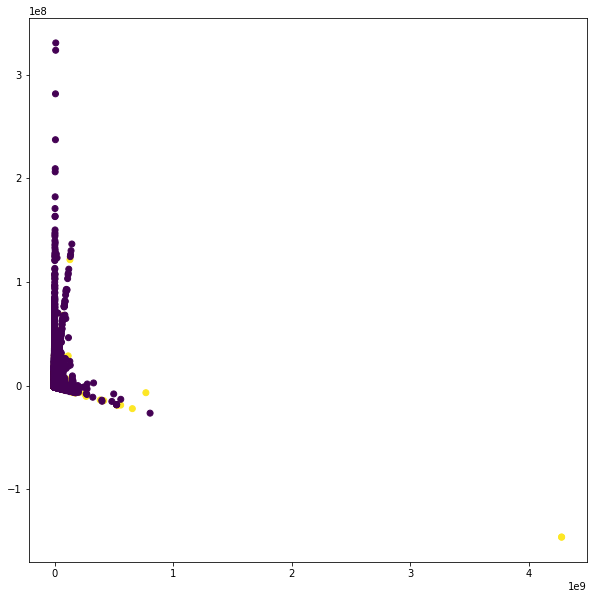

In [10]:
# perform PCA
pca = PCA()
pca.fit(X)
data_pca = pca.transform(X)
# plot the results
plt.figure(figsize=(10, 10))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=df_train['label'])


In [11]:
# train the model
X_train = df_train[feature_cols]
y_train = df_train['label']
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [12]:
# define the dataset
dc_train = Dataset(df_train, label = 'label', cat_features= [])
dc_test = Dataset(df_test, label = 'label', cat_features= [])
# define checks object
suite = full_suite()

In [13]:
# suite.run(train_dataset = dc_train, test_dataset = dc_test, model = xgb_model)

invalid value encountered in longlong_scalars


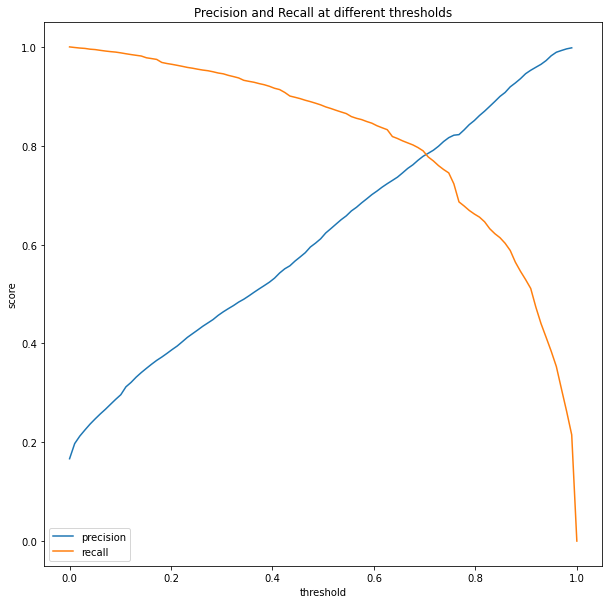

In [14]:
# get precision and recall at different thresholds
def get_precision_recall(y_true, y_pred, threshold):
    y_pred = (y_pred > threshold).astype(int)
    tp = np.sum((y_pred == 1) & (y_true == 1))
    fp = np.sum((y_pred == 1) & (y_true == 0))
    fn = np.sum((y_pred == 0) & (y_true == 1))
    tn = np.sum((y_pred == 0) & (y_true == 0))
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    return precision, recall

# get the predictions
y_pred = xgb_model.predict_proba(df_test[feature_cols])[:, 1]
# get the precision and recall at different thresholds
thresholds = np.linspace(0, 1, 100)
precisions = []
recalls = []
for threshold in thresholds:
    precision, recall = get_precision_recall(df_test['label'], y_pred, threshold)
    precisions.append(precision)
    recalls.append(recall)
# plot the results
plt.figure(figsize=(10, 10))
plt.plot(thresholds, precisions, label='precision')
plt.plot(thresholds, recalls, label='recall')
plt.legend()
plt.xlabel('threshold')
plt.ylabel('score')
plt.title('Precision and Recall at different thresholds')
plt.show()


In [15]:
# calc tpr at fpr = 0.1
y_pred = xgb_model.predict_proba(df_test[feature_cols])[:, 1]
fpr, tpr, thresholds = roc_curve(df_test['label'], y_pred)
# find the threshold that gives fpr = 0.001
wanted_fpr = 0.1
idx = np.argmin(np.abs(fpr - wanted_fpr))
wanted_tpr = tpr[idx]
print(f'TPR at FPR = {wanted_fpr}: {wanted_tpr}')

TPR at FPR = 0.1: 0.87435


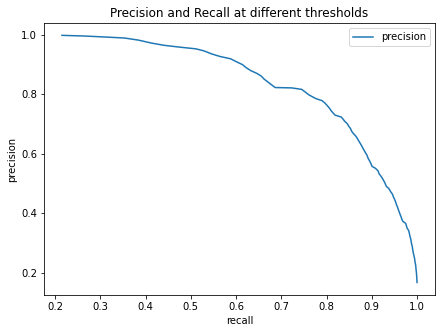

In [16]:
# plot the results
plt.figure(figsize=(7, 5))
plt.plot(recalls, precisions, label='precision')
plt.legend()
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Precision and Recall at different thresholds')
plt.show()


In [17]:
# s_data = shap.maskers.Independent(X_train)

In [18]:
# plot shap values
# explainer = shap.Explainer(xgb_model, X_train.iloc[:1000])
# shap_values = explainer(X_train.iloc[:1000])

In [19]:
# shap.plots.beeswarm(shap_values)

# Extract Results

In [20]:
# get predictions probabilities
y_test_pred = xgb_model.predict_proba(df_test[feature_cols])[:, 1]
y_train_pred = xgb_model.predict_proba(df_train[feature_cols])[:, 1]
# save to dataframes
df_test['pred'] = y_test_pred
df_train['pred'] = y_train_pred

In [31]:
# create results dataframe
train_results = df_train[['pred', 'label']]
test_results = df_test[['pred', 'label']]
# merge with vt_df
train_results = train_results.merge(vt_train_df, left_index=True, right_on='sha256',how='left')
test_results = test_results.merge(vt_test_df, left_index=True, right_on='sha256', how='left')

In [33]:
test_results.shape

(120000, 7)

In [35]:
train_results = train_results[['sha256', 'pred', 'label', 'num_undetected', 'num_malicious']]
test_results = test_results[['sha256', 'pred', 'label', 'num_undetected', 'num_malicious']]
train_results.to_csv('data/results/train_results.csv', index=False)
test_results.to_csv('data/results/test_results.csv', index=False)